In [9]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras

In [10]:
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

In [11]:
ticket = pd.read_csv('../data/perf_port(172.17.28.181).csv')
ticket.head(5)

,ip,stat_dt,bps_in,bps_out
0,172.17.28.181,1970-01-20 14:10:13,8.165731e+12,12406968.05
1,172.17.28.181,2022-08-11 19:24:00,8.166566e+12,12408211.75
2,172.17.28.181,2022-08-11 19:25:00,8.166674e+12,12408368.15
3,172.17.28.181,2022-08-11 19:27:00,8.166901e+12,12408707.65
4,172.17.28.181,2022-08-11 19:28:00,8.167026e+12,12408897.55


In [12]:
time_temp = pd.to_datetime(ticket['stat_dt'])
level_temp = ticket['bps_in']
time_temp.name = 'date'
level_temp.name = 'bps_in'

In [13]:
ticket = pd.concat([time_temp, level_temp], axis = 1)
ticket = ticket.set_index("date")
print(ticket.shape)
ticket.head(5)

(5742, 1)


,bps_in
date,
1970-01-20 14:10:13,8.165731e+12
2022-08-11 19:24:00,8.166566e+12
2022-08-11 19:25:00,8.166674e+12
2022-08-11 19:27:00,8.166901e+12
2022-08-11 19:28:00,8.167026e+12


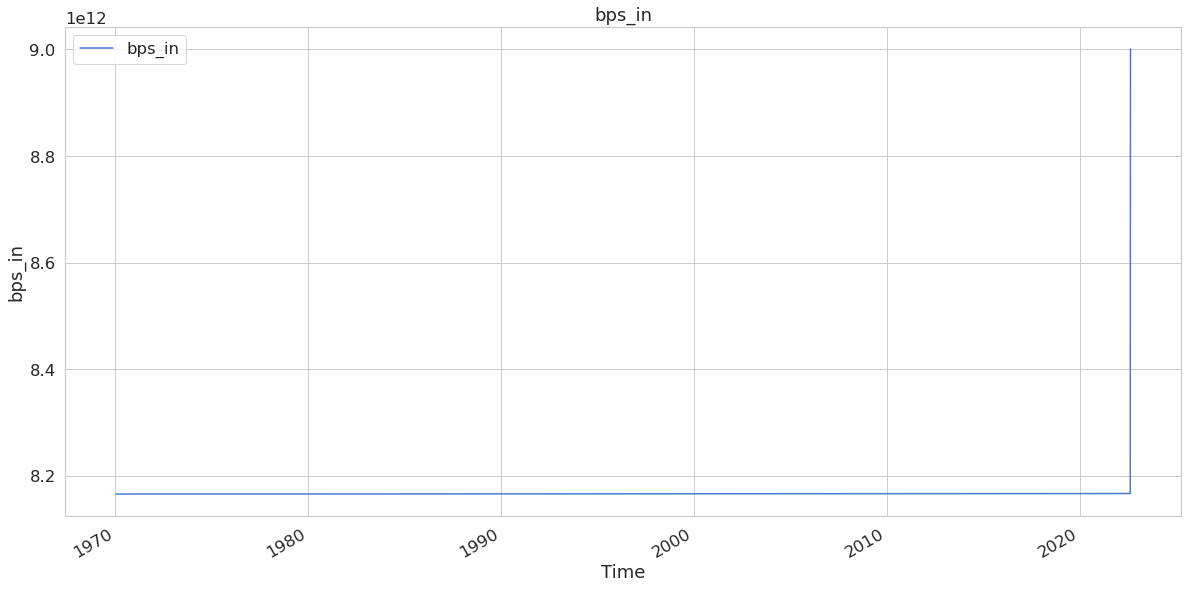

In [15]:
plt.rcParams["figure.figsize"] = (20,10)
ticket.plot()

# Set Anomaly
span_start = time_temp[4950].to_pydatetime()
span_end = time_temp[5150].to_pydatetime()
plt.axvspan(span_start, span_end, facecolor='r', alpha=0.5)

plt.title("bps_in")
plt.xlabel("Time")
plt.ylabel("bps_in")
plt.show()

## Data Normalization

In [16]:
train_size = int(len(ticket) * 0.7)
test_size = len(ticket) - train_size
train, test = ticket.iloc[0:train_size], ticket.iloc[train_size:len(ticket)]
print(train.shape, test.shape)

(4019, 1) (1723, 1)


In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['bps_in']])

train['bps_in'] = scaler.transform(train[['bps_in']])
test['bps_in'] = scaler.transform(test[['bps_in']])

/tmp/ipykernel_2074532/2899557848.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['bps_in'] = scaler.transform(train[['bps_in']])
/tmp/ipykernel_2074532/2899557848.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['bps_in'] = scaler.transform(test[['bps_in']])


## Data Preprocessing

In [20]:
def make_vector(X, Y, time_steps=1):
    Xs, Ys = [], []
    for i in range(len(X) - time_steps):
        value = X.iloc[i:(i + time_steps)].values
        Xs.append(value)        
        Ys.append(Y.iloc[i + time_steps])
    return np.array(Xs), np.array(Ys)

In [22]:
TIME_STEPS = 30

X_train, Y_train = make_vector(train[['bps_in']], train.bps_in, TIME_STEPS)
X_test, Y_test = make_vector(test[['bps_in']], test.bps_in, TIME_STEPS)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(3989, 30, 1)
(3989,)
(1693, 30, 1)
(1693,)


## LSTM Autoencoder Modeling

In [23]:
model = keras.Sequential()
model.add(keras.layers.LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

2022-08-21 15:08:20.783544: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.4/lib64
2022-08-21 15:08:20.783583: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-08-21 15:08:20.791621: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appr

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 repeat_vector (RepeatVector  (None, 30, 64)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 30, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0         
                                                                 
 time_distributed (TimeDistr  (None, 30, 1)            65        
 ibuted)                                                

In [25]:
history = model.fit(X_train, X_train, epochs=10, batch_size=32, validation_split=0.1, shuffle=False)

Epoch 1/10
113/113 [==============================] - 7s 36ms/step - loss: 0.1959 - val_loss: 0.1255
Epoch 2/10
113/113 [==============================] - 3s 29ms/step - loss: 0.1521 - val_loss: 0.1344
Epoch 3/10
113/113 [==============================] - 3s 29ms/step - loss: 0.0998 - val_loss: 0.0873
Epoch 4/10
113/113 [==============================] - 3s 30ms/step - loss: 0.1911 - val_loss: 0.0856
Epoch 5/10
113/113 [==============================] - 3s 30ms/step - loss: 0.1232 - val_loss: 0.0571
Epoch 6/10
113/113 [==============================] - 3s 29ms/step - loss: 0.2128 - val_loss: 0.2135
Epoch 7/10
113/113 [==============================] - 3s 31ms/step - loss: 0.1575 - val_loss: 0.0815
Epoch 8/10
113/113 [==============================] - 4s 33ms/step - loss: 0.2807 - val_loss: 0.0817
Epoch 9/10
113/113 [==============================] - 4s 34ms/step - loss: 0.1889 - val_loss: 0.0457
Epoch 10/10
113/113 [==============================] - 3s 31ms/step - loss: 0.2129 - val_lo

## Model Evaluation

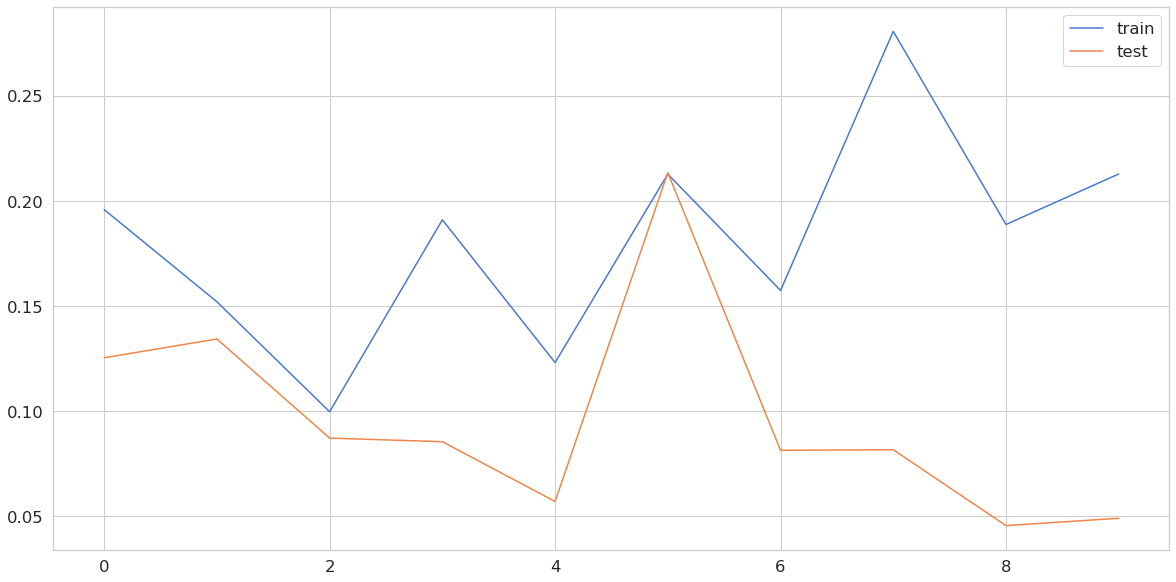

In [26]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()